# Product Analysis Agentic AI
#### Author: Iremide ~ The AI Guy
#### Description: This script sets up an agentic AI workflow for analyzing products.
#### The workflow includes internet search, content scraping, insight extraction, and visualization.


#### Workflow Overview:

1. Internet Search Tool:
   - Searches the web for information related to the target product.
   - Retrieves relevant articles, reviews, or data sources.

2. Content Scraping Tool:
   - Scrapes content from the URLs or sources retrieved in step 1.
   - Extracts textual or structured data for analysis.

3. AI Insight Extraction:
   - Passes the scraped content to an AI model.
   - Extracts insights, trends, and important product information.

4. Visualization Tool:
   - Visualizes the insights obtained from the AI.
   - Could include charts, graphs, or dashboards to interpret the data.

## Initial Steps

In [2]:
# Step 0: Mount Google Drive
# Description: This allows the Colab notebook to access files stored in your Google Drive.
# The `force_remount=True` ensures that the drive is re-mounted even if it was previously mounted.

# Usage Notes:
# - After mounting, you can access your Google Drive files directly from the Colab sidebar.
# - Click the folder icon on the left sidebar to navigate through your Drive.
# - You can open, upload, or download files directly from there, or reference them in your code.
# - This step is necessary if you store product data, saved content, or models in Drive.

from google.colab import drive
drive.mount("/content/my_drive", force_remount=True)

Mounted at /content/my_drive


In [3]:
# Step 0b: Change working directory
# Description: Set the current working directory to your project folder in Google Drive.
# This ensures that all file reads/writes happen relative to this folder.

# How to get the folder path in Colab:
# 1. Click the folder icon on the left sidebar to open the file browser.
# 2. Navigate to your project folder in "My Drive".
# 3. Right-click the folder and select "Copy path" to get the full path.
# 4. Paste that path below in place of the example path.

%cd /content/my_drive/MyDrive/Colab Notebooks/financial_research_analyzer/

/content/my_drive/MyDrive/Colab Notebooks/financial_research_analyzer


In [4]:
# Step 0c: Verify current working directory
# Description: Confirms that you are in the correct project folder.

import os

# Get and print the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content/my_drive/MyDrive/Colab Notebooks/financial_research_analyzer


In [6]:
# Step 0d: Suppress specific warning messages
# Description: Ignore DeprecationWarning and ResourceWarning to reduce clutter in notebook output.

import warnings

# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Ignore resource warnings
warnings.filterwarnings("ignore", category=ResourceWarning)

In [ ]:
# Step 0e: Install required packages
# Description: Install all Python packages needed for the product analysis agentic AI.

# Google Search API client
!pip install google-search-results

# Libraries for PDF handling, HTML parsing, and readability extraction
!pip install PyMuPDF markdownify readabilipy bs4

# OpenAI agents and core OpenAI SDK
!pip install openai-agents openai

# LiteLLM library for lightweight language model handling
!pip install litellm

# Install OpenAI agents with LiteLLM integration
!pip install openai-agents[litellm]

# mplfinance, is a visualization library.
!pip install mplfinance

In [66]:
# Step 0f: Import Necessary Libraries
from agents.extensions.models.litellm_model import LitellmModel
from agents import OpenAIChatCompletionsModel, set_default_openai_client, set_tracing_disabled, set_default_openai_api, Agent, Runner, function_tool, ItemHelpers
from google import genai
import litellm
import logging
import math
logging.getLogger("LiteLLM").setLevel(logging.WARNING)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import mplfinance as mpf
from wordcloud import WordCloud
import inspect

In [9]:
# Step 0g: Turn off tracing in the OpenAI dashboard to avoid unnecessary API key warnings

# Disable tracing
set_tracing_disabled(True)

-> Quick Note on OpenAI Agents SDK. You can Skip this if you are familiar with the library.

OpenAI Agents SDK Overview

The OpenAI Agents SDK lets you build agentic AI apps easily, providing a lightweight set of tools
to make your AI act autonomously. Imagine running a small, efficient kitchen team—this will help
you understand the four core concepts of the SDK:

1. **Agents** – These are the chefs in your kitchen (LLMs equipped with instructions and tools).
   Each chef knows what dishes they can make and which tools to use.

2. **Handoffs** – Sometimes a chef needs a specialist, like a pastry chef for desserts.
   Handoffs allow your AI agent to delegate specific tasks to other agents better suited for them.

3. **Guardrails** – Think of health and safety rules in the kitchen. Guardrails validate that
   the agent’s actions and outputs are correct, safe, and within expected bounds.

4. **Sessions** – This is the kitchen notebook that keeps track of orders and past interactions.
   Sessions automatically maintain conversation history across agent runs, so nothing is forgotten.

Together, these elements allow your AI to act, delegate, validate, and remember—like a smart,
coordinated team.

Learn more:  
- GitHub: https://github.com/openai/openai-agents-python  
- Docs: https://openai.github.io/openai-agents-python/

## Import Credentials

In [10]:
# Step 1: Load API keys and configure model
# Description: Load the API keys required for web search and AI model usage, and specify the model.
# - SERP API key: Used to perform Google searches. Sign up here for free 2,500 credits: https://serpapi.com/
# - Gemini API key: Used to access the Gemini LLM model (gemini-2.0-flash). Create this key in Google Cloud Console.
#     - Tutorial: https://www.merge.dev/blog/gemini-api-key
# - Model: Specify the LLM model to use; can be changed if desired. The gemini-2.0-flash is free to use.

# Storing API keys in Google Colab:
# 1. Click the "User data" tab in the left sidebar.
# 2. Add your keys:
#    - Key name: serp_api_key, Value: your SERP API key
#    - Key name: gemini_api_key, Value: your Gemini API key
# 3. Save. The keys can now be accessed in your notebook using userdata.get('key_name').

from google.colab import userdata

# Load keys from Colab userdata
serp_api_key = userdata.get('serp_api_key')       # Google SERP API key
gemini_api_key = userdata.get("gemini_api_key")   # Google Gemini API key

# Specify which model to use; can be changed if desired
model_name = "gemini/gemini-2.0-flash"

## [Optional] Simpler Agent

This section explains how an OpenAI Agent works in different scenarios, from simple instruction-only usage to using tools and streaming.
It's optional for beginners who want to understand the mechanics before diving into the full orchestrator agent.

In [35]:
messy_text_sample = """ I’m Iremide ~ The AI Guy. I specialize in AI and Machine Learning, with a particular focus on building agentic AI systems for businesses. Over the past 3 years, I have gained hands-on experience working in the industry, designing and implementing scalable AI solutions that solve real-world problems.
                        My work spans multiple domains within Data Science and Machine Learning. I develop models from scratch, ranging from classical regression and classification models to advanced deep learning architectures, including LSTMs, CNNs, and Transformers. I have experience with both structured and unstructured data, enabling me to tackle diverse challenges—from predictive analytics and natural language processing to computer vision applications.
                        Beyond technical expertise, I am passionate about turning complex AI concepts into actionable business insights. I collaborate closely with stakeholders to ensure that AI systems are not only technically robust but also aligned with business goals. I enjoy creating agentic systems that automate workflows, extract valuable insights from large datasets, and assist decision-making processes.
                        In addition to building AI systems, I contribute to the AI community by sharing knowledge, writing guides, and mentoring aspiring data scientists. My goal is to bridge the gap between cutting-edge research and practical applications, helping organizations leverage AI to drive innovation and efficiency.
                        When I’m not building models or developing AI solutions, I enjoy exploring new technologies, reading about advancements in AI, and experimenting with innovative ideas that push the boundaries of machine intelligence."""

In [37]:
# 1. **Agent with instruction and user input only**
#    - The agent can reason, plan, and generate responses based purely on:
#        • Instructions (its role or persona)
#        • User input (the question or request)
#    - Example: Ask the agent to summarize a paragraph.
# """
agent = Agent(
    name="Assistant",
    instructions="You are a helpful assistant.", # Feel free to tweak the instructions to whatever you want.
    model=LitellmModel(model_name, api_key=gemini_api_key)
)
response = await Runner.run(starting_agent=agent, input=f"Summarize the following text in few sentences: '{messy_text_sample}'")
print(response.final_output)

Iremide, "The AI Guy," is an AI and Machine Learning specialist with 3 years of industry experience, focusing on building agentic AI systems for businesses. He develops models from scratch, works with diverse data types, and translates complex AI concepts into actionable business insights. Beyond building AI solutions, Iremide also contributes to the AI community by sharing knowledge and mentoring others.



In [42]:
# 2. **Agent with instruction + ability to call a tool**
#    - The agent can now use tools to fetch real-time information or perform actions.
#    - Example: A "get_weather" tool fetches current weather from an API.
#    - This enables the agent to provide dynamic, data-backed answers.

@function_tool
def get_weather(location: str) -> str:
    # Dummy tool: In practice, calls a weather API
    return f"The current temperature in {location} is 25°C."

tools = [get_weather]
agent_with_tools = Agent(
    name="assistant",
    instructions="You are a smart assistant with access to tools.",
    model=LitellmModel(model_name, api_key=gemini_api_key),
    tools=tools
)
response = await Runner.run(starting_agent=agent_with_tools, input="Check the weather in New York.")
print(response.final_output)


OK. The current temperature in New York is 25°C.



In [51]:
# 3. **Agent with streaming**
#    - Streaming lets you see the agent's reasoning in real time, providing insights into its thought process.
#    - Useful for long-running tasks or complex workflows where waiting for the final output is inefficient.
#    - Outputs are generated as a series of events instead of a single response.
#    - This technique can also be leveraged to "hijack" intermediate results, capture tool calls, or dynamically process data, as implemented in the `Financial Research Agent`.

result = Runner.run_streamed(agent_with_tools, "Check the weather in Paris.", max_turns=5)


print("=== Run starting ===\n")
async for event in result.stream_events():
  # We'll ignore the raw responses event deltas)
  if event.type == "raw_response_event":
      continue
  elif event.type == "agent_updated_stream_event":
      print(f"Agent updated: {event.new_agent.name}")
      continue
  elif event.type == "run_item_stream_event":
      if event.item.type == "tool_call_item":
        tool_args = event.item.raw_item.arguments
        tool_name = event.item.raw_item.name
        print(f"-- {tool_name} Tool was called with arguments {tool_args}")
      elif event.item.type == "tool_call_output_item":
          print(f"-- {tool_name} Tool output: {event.item.output}")
      elif event.item.type == "message_output_item":
          print(f"-- Agent Final output:\n {ItemHelpers.text_message_output(event.item)}")
      else:
          pass  # Ignore other event types

print("=== Run complete ===")

=== Run starting ===

Agent updated: assistant
-- get_weather Tool was called with arguments {"location": "Paris"}
-- get_weather Tool output: The current temperature in Paris is 25°C.
-- Agent Final output:
 OK. The current temperature in Paris is 25°C.

=== Run complete ===


## Web Search Tool

In [11]:
# Step 2: Internet Search Tool using SERP API
# Description: Fetches the top 5 Google search results for a given query using the SERP API.
# Each result contains the title, snippet, and link.

import http.client
import json

def fetch_google_news_serpapi(query):
    """
    Perform a Google search via SERP API and return top results.

    Args:
        query (str): The search query string.

    Returns:
        list of dict: Each dictionary contains 'title', 'snippet', and 'link'.
    """

    # Connect to the SERP API endpoint
    conn = http.client.HTTPSConnection("google.serper.dev")

    # Prepare the request payload
    payload = json.dumps({
        "q": query,   # search query
        "num": 5,     # number of results to fetch
        "gl": "us",   # geolocation (US)
        "hl": "en"    # language (English)
    })

    # Headers with API key
    headers = {
        'X-API-KEY': serp_api_key,
        'Content-Type': 'application/json'
    }

    # Send POST request
    conn.request("POST", "/search", payload, headers)

    # Get the response
    res = conn.getresponse()
    data = res.read()

    # Parse JSON response
    results = json.loads(data.decode("utf-8"))
    results = results.get("organic")  # Extract organic search results

    # Prepare final simplified list
    final_results = []
    for web_result in results:
        result = {
            "title": web_result.get("title"),
            "snippet": web_result.get("snippet"),
            "link": web_result.get("link")
        }
        final_results.append(result)

    return final_results

In [12]:
# Test the web search function
results = fetch_google_news_serpapi("Impact of ChatGPT in the society")

In [13]:
results

[{'title': 'ChatGPT in society: emerging issues - Frontiers',
  'snippet': 'It has the potential to undermine the quality of education and critical thinking skills. And it could promote plagiarism and dishonesty.” There ...',
  'link': 'https://www.frontiersin.org/journals/artificial-intelligence/articles/10.3389/frai.2023.1130913/full'},
 {'title': 'ChatGPT: Legal implications and societal impact',
  'snippet': 'ChatGPT has the potential to make information and services more accessible to a broader audience but has also raised concerns about job ...',
  'link': 'https://meng.uic.edu/news-stories/chatgpt-legal-implications-and-societal-impact/?utm_source=Content&utm_medium=Blog+Article&utm_campaign=Information_Artificial+Intelligence'},
 {'title': 'Exploring ChatGPT and its impact on society | AI and Ethics',
  'snippet': 'On one hand, ChatGPT enhances communication, streamlines tasks, and fosters accessibility, bolstering productivity and convenience. On the other ...',
  'link': 'htt

## Web Scraper Tool

In [16]:
# Step 3: Content Extraction Tool
# Description:
# - This module fetches and cleans content from URLs or PDFs for downstream AI analysis.
# - Handles PDFs, HTML pages, and plain text.
# - For HTML, it extracts readable content, converts it to Markdown, and appends inline links like "text (url)".
# - For PDFs, it extracts text from all pages and inlines links found in the document.
# - Includes basic text cleaning: normalizes line breaks, removes extra spaces, and ensures tidy formatting.
# - Designed to work asynchronously for faster fetching of multiple URLs.

# Key Functions:
# 1. clean_text_basic(text) → Cleans and normalizes raw text.
# 2. _normalize_and_clean_url(href, base_url) → Resolves relative URLs and cleans them.
# 3. _extract_content_with_inline_links(html, base_url) → Extracts readable content from HTML, preserves links.
# 4. extract_text_from_url(url) → Main function to fetch content from a URL/PDF and return cleaned text with inline links.

In [58]:
import re
import aiohttp
import fitz  # PyMuPDF
import asyncio
import markdownify
import readabilipy.simple_json
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from typing import List, Dict, Any


def clean_text_basic(text: str) -> str:
    if not text:
        return ""
    text = text.replace("\\n", "\n").replace("\r", "\n")
    text = re.sub(r"\n{2,}", "\n\n", text)
    text = re.sub(r"[ \t]{2,}", " ", text)
    return text.strip()


def _normalize_and_clean_url(href: str, base_url: str | None = None) -> str:
    if not href:
        return ""
    href = href.strip()
    # remove surrounding punctuation
    href = href.strip(" \n\t'\"<>.,;:()[]{}")
    # handle protocol-relative URLs
    if href.startswith("//"):
        href = "https:" + href
    # resolve relative URLs if base provided
    try:
        if base_url and not bool(urlparse(href).netloc):
            href = urljoin(base_url, href)
    except Exception:
        pass
    return href


async def _extract_content_with_inline_links(html: str, base_url: str | None = None) -> str:
    """
    Extracts readable content from HTML and ensures all anchor texts are followed
    by their link in parentheses, like: "Some text (https://example.com)".
    """
    soup = BeautifulSoup(html, "html.parser")

    # Replace <a> tags with "text (url)" format
    for a in soup.find_all("a"):
        href = _normalize_and_clean_url(a.get("href"), base_url)
        if href:
            # append link in parentheses if anchor has text
            if a.text.strip():
                a.replace_with(f"{a.text.strip()} ({href})")
            else:
                a.replace_with(href)

    # Extract text content with readability + markdownify fallback
    def sync_html():
        try:
            ret = readabilipy.simple_json.simple_json_from_html_string(
                str(soup), use_readability=True
            )
            if not ret.get("content"):
                return "<error>Failed to simplify HTML content</error>"
            return markdownify.markdownify(ret["content"], heading_style=markdownify.ATX)
        except Exception:
            return soup.get_text(" ")

    return await asyncio.to_thread(sync_html)


async def extract_text_from_url(url: str) -> Dict[str, Any]:
    """
    Fetch URL and return a dict:
      {
        "text": "<cleaned markdown with inline links>"
      }
    Falls back to {"text": ""} on any error.
    """
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as resp:
                content_type = resp.headers.get("Content-Type", "") or ""
                content_bytes = await resp.read()

        # PDF handling — we can only inline plain-text links
        if url.lower().endswith(".pdf") or "application/pdf" in content_type.lower():
            try:
                texts = []
                for page in fitz.open(stream=content_bytes, filetype="pdf"):
                    texts.append(page.get_text())
                raw_text = "\n".join(texts)
                clean_text = clean_text_basic(raw_text)
                # Inline links: replace with "(link)" next to them if found
                found_links = re.findall(r"https?://[^\s\"'<>)+,;]+", raw_text)
                for link in found_links:
                    clean_text = clean_text.replace(link, f"({link})")
                return clean_text
            except Exception as e:
                return None

        # Non-PDF: decode to string
        try:
            text = content_bytes.decode("utf-8", errors="ignore")
        except Exception:
            text = content_bytes.decode(errors="ignore")

        # If looks like HTML, process with readability and inline anchor links
        if ("<html" in text[:200].lower()) or ("text/html" in content_type.lower()) or not content_type:
            try:
                cleaned_markdown = await _extract_content_with_inline_links(text, base_url=url)
            except Exception:
                cleaned_markdown = ""
            return clean_text_basic(cleaned_markdown)

        # Fallback: treat raw response as plain text, inline any URLs
        cleaned = clean_text_basic(text)
        found_links = re.findall(r"https?://[^\s\"'<>)+,;]+", text)
        for link in found_links:
            cleaned = cleaned.replace(link, f"({link})")
        return cleaned

    except Exception as e:
        print(e)
        return None


In [15]:
# Test Extraction Tool
await extract_text_from_url(results[0].get("link"))

"Whether it’s based on hallucinatory beliefs or not, an artificial-intelligence gold rush has started over the last several months to mine the anticipated business opportunities from generative AI models like ChatGPT. App developers, venture-backed startups, and some of the world’s largest corporations are all scrambling to make sense of the sensational text-generating bot released by OpenAI last November.\n\nYou can practically hear the shrieks from corner offices around the world: “What is our ChatGPT play? How do we make money off this?”\n\nBut while companies and executives see a clear chance to cash in, the likely impact of the technology on workers and the economy on the whole is far less obvious. Despite their limitations—chief among of them their propensity for making stuff up—ChatGPT and other recently released generative AI models hold the promise of automating all sorts of tasks that were previously thought to be solely in the realm of human creativity and reasoning, from wr

## Web Search + Scraper Tool

In [17]:
# Step 4: Web Search Tool as a Function Tool

# - `@function_tool`: This decorator registers a Python function as a "tool" that an OpenAI agent can use.
#   Tools are callable actions that the agent can execute to perform specific tasks.

# - `web_search_tool(query)`:
#   1. Performs a Google search using `fetch_google_news_serpapi`.
#   2. For each search result, fetches and cleans the content from the link using `extract_text_from_url`.
#   3. Runs all content fetches concurrently with `asyncio.gather` for speed.
#   4. Returns a list of results, each containing:
#      - title
#      - snippet
#      - link
#      - cleaned content of the webpage or PDF

# - Coupling the search and content extraction functions together into one tool allows the agent to:
#   1. Take a query as input.
#   2. Search the web autonomously.
#   3. Retrieve the full readable content from the top results.

# - This tool can now be passed to an agent, enabling it to perform searches and process websites automatically
#   as part of its decision-making and reasoning workflow.

In [59]:
import asyncio

@function_tool # This is used to register a function as a function tool.
async def web_search_tool(query):
    web_results = fetch_google_news_serpapi(query=query)
    if not web_results:
        return []

    async def fetch_content(result):
        link = result.get("link")
        result['content'] = await extract_text_from_url(link)
        return result

    # Run all fetches concurrently
    web_results_with_content = await asyncio.gather(*(fetch_content(r) for r in web_results))

    return web_results_with_content

In [ ]:
# Note:
# Function tools registered with `@function_tool` are meant to be used by an OpenAI agent.
# They cannot be called like regular Python functions in the usual way.
# Running `await web_search_tool("Impact of ChatGPT on the economy")` directly in a cell
# will throw an error.
# To use this tool, pass it to an agent, which can then call it as part of its workflow.
await web_search_tool("Impact of ChatGPT on the economy")

## Visualization Functions


Step 5: Visualization & Post-Processing Tool Handling. This might be a bit tricky, but follow along, you'll get it.

1. **Purpose of Dummy Functions**
   - In OpenAI Agents, `@function_tool` functions must return a string.
   - Real visualization functions (matplotlib, seaborn, WordCloud, etc.) return figures, not strings.
   - To work around this, we create "dummy" tools that:
     • Have the same signature as the real plotting functions.
     • Return a simple string like "plot successful".
   - These dummy tools allow the agent to "call" a tool while streaming, without breaking execution.

2. **Mapping to Real Functions**
   - `function_tool_map` links each dummy function name to its actual plotting implementation.
   - During agent execution, we hijack the function call arguments:
     • Capture the tool name and arguments from the agent's tool call events.
     • Store them in a list `plot_funcs` along with the real function reference.
   - After the agent run is complete, we can loop over `plot_funcs` and call the real plotting functions with the captured arguments to generate figures.

3. **Why This Matters**
   - Enables **post-processing of plots** after the agent has finished reasoning.
   - Maintains the streaming workflow while still producing real visualizations.
   - Keeps a clean separation between agent logic (decision-making) and rendering visual outputs.
   - Allows the agent to use multiple visualization tools dynamically, while adhering to the constraints of `@function_tool`.

4. **Integration in `ProductResearcher`**
   - `web_search_tool` is called first to gather data.
   - Agent decides which visualization tools to use and provides arguments.
   - `plot_funcs` collects the real plotting function and arguments.
   - After streaming is complete, the plots can be generated for the final report.


#### Dummy Function Tools

In [22]:
# Dummy Functions. The docstrings are necessary, to help the AI understand the description of each tool.
@function_tool
def plot_bar_chart(categories, values, title="Bar Chart", xlabel="Categories", ylabel="Values", color=None):
    """
    Create a vertical bar chart.

    Parameters:
    - categories (list[str]): Categories to display on the x-axis.
    - values (list[int|float]): Corresponding numerical values for each category.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str, optional): Color for bars. If not provided, default color is used

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_stacked_bar_chart(categories, data, title="Stacked Bar Chart", xlabel="Categories", ylabel="Values"):
    """
    Create a stacked bar chart.

    Parameters:
    - categories (list[str]): Categories on the x-axis.
    - data (dict): Dictionary where keys are subgroups and values are lists of numbers for each category.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_pie_chart(labels, values, title="Pie Chart"):
    """
    Create a pie chart.

    Parameters:
    - labels (list[str]): Categories represented in the pie.
    - values (list[int|float]): Numerical values for each category.
    - title (str): Chart title.
    - autopct (str): Percentage label format.
    - startangle (int): Rotation for the start of the pie chart.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_line_chart(x, y, title="Line Chart", xlabel="X", ylabel="Y", color="blue"):
    """
    Create a line chart.

    Parameters:
    - x (list[str|datetime]): X-axis values.
    - y (list[int|float]): Y-axis values.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str): Line color.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_area_chart(x, y, title="Area Chart", xlabel="X", ylabel="Y", color="lightblue"):
    """
    Create an area chart.

    Parameters:
    - x (list[str|datetime]): X-axis values.
    - y (list[int|float]): Y-axis values.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str): Fill color.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_histogram(values, bins=10, title="Histogram", xlabel="Value", ylabel="Frequency", color="purple"):
    """
    Create a histogram.

    Parameters:
    - values (list[int|float]): Data points to distribute into bins.
    - bins (int): Number of bins.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str): Bar color.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_scatter_chart(x, y, title="Scatter Plot", xlabel="X", ylabel="Y", color="green"):
    """
    Create a scatter plot.

    Parameters:
    - x (list[int|float]): X-axis values.
    - y (list[int|float]): Y-axis values.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str): Marker color.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_box_chart(values, title="Box Plot", ylabel="Values"):
    """
    Create a box plot.

    Parameters:
    - values (list[int|float]): Data values to summarize distribution.
    - title (str): Chart title.
    - ylabel (str): Label for y-axis.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_word_cloud(text, title="Word Cloud", max_words=100):
    """
    Generate a word cloud visualization.

    Parameters:
    - text (str): Input text to generate cloud.
    - title (str): Chart title.
    - max_words (int): Maximum number of words to display.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_heatmap(data, labels, title="Heatmap", cmap="Blues"):
    """
    Create a heatmap.

    Parameters:
    - data (list[list[float]]): 2D matrix of values.
    - labels (list[str]): Axis labels for rows and columns.
    - title (str): Chart title.
    - cmap (str): Color map scheme.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_candlestick_chart(dates, open_prices, high_prices, low_prices, close_prices, title="Candlestick Chart"):
    """
    Create a candlestick chart for stock market data.

    Parameters:
    - dates (list[str|datetime]): Dates for x-axis.
    - open_prices (list[float]): Opening prices.
    - high_prices (list[float]): Highest prices.
    - low_prices (list[float]): Lowest prices.
    - close_prices (list[float]): Closing prices.
    - title (str): Chart title.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_moving_average_chart(dates, values, window=7, title="Moving Average Chart", xlabel="Date", ylabel="Value"):
    """
    Create a moving average line chart.

    Parameters:
    - dates (list[str|datetime]): Dates for x-axis.
    - values (list[float]): Values to calculate moving average.
    - window (int): Rolling window size.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_stacked_area_chart(x, data, title="Stacked Area Chart", xlabel="X", ylabel="Value"):
    """
    Create a stacked area chart.

    Parameters:
    - x (list[str|datetime]): X-axis values.
    - data (dict): Dictionary of series to stack, with labels as keys and lists of values.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"
@function_tool
def plot_bubble_chart(x, y, sizes, title="Bubble Chart", xlabel="X", ylabel="Y", color="blue"):
    """
    Create a bubble chart.

    Parameters:
    - x (list[int|float]): X-axis values.
    - y (list[int|float]): Y-axis values.
    - sizes (list[int|float]): Sizes of bubbles.
    - title (str): Chart title.
    - xlabel (str): Label for x-axis.
    - ylabel (str): Label for y-axis.
    - color (str): Bubble color.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"


@function_tool
def plot_donut_chart(labels, values, title="Donut Chart"):
    """
    Create a donut chart.

    Parameters:
    - labels (list[str]): Categories represented in the donut chart.
    - values (list[int|float]): Numerical values for each category.
    - title (str): Chart title.

    Returns:
    - str: Dummy return "plot successful"
    """
    return "plot successful"

#### Main Visualization Functions

In [24]:
# =============================
# 1. Bar Chart
# =============================
def plot_bar_chart_main(categories: list, values: list, title: str = "Bar Chart", xlabel: str = "Category", ylabel: str = "Value", color: str = "skyblue", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.bar(categories, values, color=color)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 2. Stacked Bar Chart
# =============================
def plot_stacked_bar_chart_main(categories: list, data: dict, title: str = "Stacked Bar Chart", xlabel: str = "Category", ylabel: str = "Value", ax=None):
    df = pd.DataFrame(data, index=categories)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    df.plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 3. Pie Chart
# =============================
def plot_pie_chart_main(labels: list, values: list, title: str = "Pie Chart", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(title, fontsize=14, fontweight="bold")
    return fig

# =============================
# 4. Line Chart
# =============================
def plot_line_chart_main(x: list, y: list, title: str = "Line Chart", xlabel: str = "X", ylabel: str = "Y", color: str = "blue", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.plot(x, y, color=color, linewidth=2)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.6)
    return fig

# =============================
# 5. Area Chart
# =============================
def plot_area_chart_main(x: list, y: list, title: str = "Area Chart", xlabel: str = "X", ylabel: str = "Y", color: str = "lightblue", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.fill_between(x, y, color=color, alpha=0.6)
    ax.plot(x, y, color="blue")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 6. Histogram
# =============================
def plot_histogram_main(values: list, bins: int = 10, title: str = "Histogram", xlabel: str = "Value", ylabel: str = "Frequency", color: str = "purple", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.hist(values, bins=bins, color=color, edgecolor="black", alpha=0.7)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 7. Scatter Plot
# =============================
def plot_scatter_chart_main(x: list, y: list, title: str = "Scatter Plot", xlabel: str = "X", ylabel: str = "Y", color: str = "green", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.scatter(x, y, color=color, alpha=0.7)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 8. Box Plot
# =============================
def plot_box_chart_main(values: list, title: str = "Box Plot", ylabel: str = "Values", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.boxplot(values)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 9. Word Cloud
# =============================
def plot_word_cloud_main(text: str, title: str = "Word Cloud", max_words: int = 100, ax=None):
    wordcloud = WordCloud(width=800, height=400, max_words=max_words, background_color="white").generate(text)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title, fontsize=14, fontweight="bold")
    return fig

# =============================
# 10. Heatmap
# =============================
def plot_heatmap_main(data: list, labels: list, title: str = "Heatmap", cmap: str = "Blues", ax=None):
    df = pd.DataFrame(data, columns=labels, index=labels)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    sns.heatmap(df, annot=True, fmt=".2f", cmap=cmap, cbar=True, ax=ax)
    ax.set_title(title, fontsize=14, fontweight="bold")
    return fig

# =============================
# 11. Candlestick Chart
# =============================
def plot_candlestick_chart_main(dates: list, open_prices: list, high_prices: list, low_prices: list, close_prices: list, title: str = "Candlestick Chart", ax=None):
    data = pd.DataFrame({
        "Open": open_prices,
        "High": high_prices,
        "Low": low_prices,
        "Close": close_prices
    }, index=pd.to_datetime(dates))
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    mpf.plot(data, type="candle", ax=ax, style="yahoo", show_nontrading=False)
    ax.set_title(title, fontsize=14, fontweight="bold")
    return fig

# =============================
# 12. Moving Average Chart
# =============================
def plot_moving_average_chart_main(dates: list, values: list, window: int = 7, title: str = "Moving Average Chart", xlabel: str = "Date", ylabel: str = "Value", ax=None):
    df = pd.DataFrame({"Date": pd.to_datetime(dates), "Value": values})
    df["MA"] = df["Value"].rolling(window=window).mean()
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.plot(df["Date"], df["Value"], label="Raw", color="blue", alpha=0.6)
    ax.plot(df["Date"], df["MA"], label=f"{window}-period MA", color="red", linewidth=2)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.6)
    return fig

# =============================
# 13. Stacked Area Chart
# =============================
def plot_stacked_area_chart_main(x: list, data: dict, title: str = "Stacked Area Chart", xlabel: str = "X", ylabel: str = "Value", ax=None):
    df = pd.DataFrame(data, index=x)
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    ax.stackplot(df.index, df.T, labels=df.columns, alpha=0.8)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc="upper left")
    return fig

# =============================
# 14. Bubble Chart
# =============================
def plot_bubble_chart_main(x: list, y: list, sizes: list, title: str = "Bubble Chart", xlabel: str = "X", ylabel: str = "Y", color: str = "blue", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    scatter = ax.scatter(x, y, s=sizes, alpha=0.5, c=color)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig

# =============================
# 15. Donut Chart
# =============================
def plot_donut_chart_main(labels: list, values: list, title: str = "Donut Chart", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    wedges, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=90, wedgeprops=dict(width=0.4))
    ax.set_title(title, fontsize=14, fontweight="bold")
    return fig


In [26]:
function_tool_map = {
    "plot_bar_chart": plot_bar_chart_main,
    "plot_stacked_bar_chart": plot_stacked_bar_chart_main,
    "plot_pie_chart": plot_pie_chart_main,
    "plot_line_chart": plot_line_chart_main,
    "plot_area_chart": plot_area_chart_main,
    "plot_histogram": plot_histogram_main,
    "plot_scatter_chart": plot_scatter_chart_main,
    "plot_box_chart": plot_box_chart_main,
    "plot_word_cloud": plot_word_cloud_main,
    "plot_heatmap": plot_heatmap_main,
    "plot_candlestick_chart": plot_candlestick_chart_main,
    "plot_moving_average_chart": plot_moving_average_chart_main,
    "plot_stacked_area_chart": plot_stacked_area_chart_main,
    "plot_bubble_chart": plot_bubble_chart_main,
    "plot_donut_chart": plot_donut_chart_main
}

## AI System:


Step 6: Orchestrator AI System

- This agent is the **main orchestrator** of the workflow.
- Responsibilities:
  1. Calls the `web_search_tool` to fetch relevant web content.
  2. Delegates post-processing tasks, like visualizations, to the respective tools.
  3. Analyzes the collected content to extract actionable insights.
  4. Combines the results and visualizations into a coherent, business-ready report.
- Think of it as the **project manager**: it coordinates all tools, ensures the workflow is followed, and produces the final output.

In [67]:
class ProductResearcher():
  def __init__(self):
    self.tools = [web_search_tool, plot_pie_chart, plot_word_cloud, plot_line_chart, plot_bar_chart]
    self.agent = Agent(
        instructions="""
            You are a **Financial & Business Research Analyst AI**. Your role is to behave like a professional data analyst hired to provide actionable, data-driven insights.
            Your workflow should follow these steps:

            1. **Web Research**
              - Always begin with the `web_search_tool` to gather reliable, structured, and measurable data from the internet.
              - Focus on sources that include financial indicators, market trends, business performance metrics, survey results, ratings, or other quantitative insights.

            2. **Visualization & Data Analysis**
              - After collecting data, you must use **at least five different visualization tools** to explain different aspects of your findings.
              - Select the **most appropriate visualization tool** for each dataset. For example:
                  • Use line charts for time-series trends.
                  • Use pie or donut charts for proportions.
                  • Use bar or stacked bar charts for categorical comparisons.
                  • Use heatmaps, scatter, or bubble charts for correlation patterns.
                  • Use candlestick or moving averages for stock/financial markets.
                  • Use word clouds for qualitative insights from text.
              - Each visualization must reveal a unique perspective of the research — avoid redundancy.

            3. **Insight Generation & Reporting**
              - Present your results as if you are writing a **business analysis report**.
              - For each visualization, provide a clear explanation of what it shows and why it matters in the context of the query.
              - Correlate the plots with your narrative, highlighting trends, risks, opportunities, and key takeaways.
              - Your explanations should sound like a financial consultant briefing executives: concise, professional, and actionable.

            **Persona Notes**
            - Be precise, analytical, and professional.
            - Prioritize clarity and insights backed by data.
            - Your goal is not just to show charts, but to deliver a **story with evidence** that supports better business decisions.

            **Rules for Tool Usage**
            - You must always call `web_search_tool` first to collect data.
            - You must always call **at least five different visualization tools**.
            - You must always choose the **best tool for the data type**, not randomly.
            - Your final output must combine **executive-style commentary** with the generated visualizations.
            """,
            name="ProductResearchAnalyst",
            model=LitellmModel(model_name, api_key=gemini_api_key),
            tools=self.tools
          )

  async def run(self, user_input):
    # Start the agent in streamed mode, allowing us to capture intermediate events
    result = Runner.run_streamed(self.agent, user_input, max_turns=30)

    # This list will store tuples of (real plotting function, arguments)
    plot_funcs = []

    print("=== Run starting ===")

    # Stream events from the agent as they are generated
    async for event in result.stream_events():
        # Each event has a type, e.g., raw_response_event, tool_call_item, etc.
        print(event.type)

        if event.type == "raw_response_event":
            # Raw response deltas from the agent – we ignore these for this workflow
            continue

        elif event.type == "agent_updated_stream_event":
            # Agent was updated (e.g., instructions or internal state changed)
            print(f"Agent updated: {event.new_agent.name}")
            continue

        elif event.type == "run_item_stream_event":
            print(f"-- Tool was called")

            if event.item.type == "tool_call_item":
                # Agent requested a tool to be called
                tool_args = event.item.raw_item.arguments  # arguments passed by the agent
                tool_name = event.item.raw_item.name
                print(f"-- {tool_name} Tool was called")

                if tool_name != "web_search_tool":
                    # Skip web_search_tool because we handle it separately
                    tool_func = function_tool_map.get(tool_name)  # Map dummy tool name to real function

                    if tool_func:
                        # Store the real function and its arguments for post-processing
                        plot_funcs.append((tool_func, tool_args))

            elif event.item.type == "tool_call_output_item":
                # Captures the output returned by a tool call
                print(f"-- Tool output: {event.item.output}")

            elif event.item.type == "message_output_item":
                # Captures text messages generated by the agent
                print(f"-- Message output:\n {ItemHelpers.text_message_output(event.item)}")

            else:
                # Ignore any other less common event types
                pass

    print("=== Run complete ===")

    # Return both the streamed result and the collected plotting function calls
    return result.final_output, plot_funcs

In [68]:
response, plot_funcs = await ProductResearcher().run("what is the current update on AI in the world")

=== Run starting ===
agent_updated_stream_event
Agent updated: ProductResearchAnalyst
raw_response_event
raw_response_event
raw_response_event
run_item_stream_event
-- Tool was called
-- web_search_tool Tool was called
raw_response_event
raw_response_event

run_item_stream_event
-- Tool was called
-- Tool output: [{'title': 'The Current Status Of Artificial Intelligence - All Tech Magazine', 'snippet': 'AI technologies have made significant advancements in various fields, including natural language processing, image recognition, and automation. These ...', 'link': 'https://alltechmagazine.com/what-is/current-status-of-artificial-intelligence/', 'content': 'To truly grasp the idea of what is the current status of Artificial Intelligence (AI), we must start by dissecting its very definition and understanding the evolution of “intelligence” and how the concept of “intelligence” has changed within AI.\n\nAs AI continues to develop, our understanding of what it means for a system to be inte

In [71]:
response

"**Analysis:** This bar chart illustrates the relative importance of different ethical considerations in AI development. Fairness, transparency, accountability, privacy, and security are all crucial aspects that need to be addressed to ensure responsible AI development and deployment.\n\nIn conclusion, AI is rapidly evolving and transforming various aspects of our lives. While AI offers tremendous potential, it's crucial to address ethical considerations and challenges to ensure its responsible and beneficial use. The future of AI will be shaped by continued innovation, collaboration, and a focus on creating AI systems that are fair, transparent, and accountable.\n"

In [72]:
plot_funcs

[(<function __main__.plot_pie_chart_main(labels: list, values: list, title: str = 'Pie Chart', ax=None)>,
  '{"title": "AI Adoption Rate Among Large Companies", "labels": ["2018", "Current"], "values": [53, 100]}'),
 (<function __main__.plot_bar_chart_main(categories: list, values: list, title: str = 'Bar Chart', xlabel: str = 'Category', ylabel: str = 'Value', color: str = 'skyblue', ax=None)>,
  '{"categories": ["Healthcare", "Finance", "Retail", "Manufacturing", "Transportation"], "ylabel": "Investment (Relative)", "title": "AI Investment by Sector (Relative)", "color": "green", "xlabel": "Sector", "values": [90, 80, 70, 60, 50]}'),
 (<function __main__.plot_line_chart_main(x: list, y: list, title: str = 'Line Chart', xlabel: str = 'X', ylabel: str = 'Y', color: str = 'blue', ax=None)>,
  '{"title": "Growth of AI Model Parameters", "xlabel": "Year", "ylabel": "Parameters (Millions)", "x": ["2018", "2019", "2020", "2021", "2022", "2023"], "color": "red", "y": [100, 200, 400, 800, 160

## Post Processing: Plot Visualizations

In [73]:
def plot_figure(plot_funcs):
    # Determine how many plots the agent requested
    n_plots = len(plot_funcs)
    if n_plots == 0:
        print("No plots generated by the agent.")
        return

    # Arrange subplots in a grid (2 columns)
    ncols = 2
    nrows = math.ceil(n_plots / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 5*nrows))

    # Flatten axes for easy iteration (axes can be 1D or 2D depending on nrows/ncols)
    axes = axes.flatten() if n_plots > 1 else [axes]

    for ax, (func, args) in zip(axes, plot_funcs):
        # If arguments were serialized as JSON string, deserialize them
        if isinstance(args, str):
            args = json.loads(args)

        # Handle special case: some tools use "labels" instead of "categories"
        if func.__name__ == "plot_bar_chart_main":
            if "labels" in args and "categories" not in args:
                args["categories"] = args.pop("labels")

        # Inspect function signature to know which arguments are valid
        sig = inspect.signature(func)
        valid_params = set(sig.parameters.keys())

        # Filter out any extra arguments the function doesn't accept
        filtered_args = {k: v for k, v in args.items() if k in valid_params}

        # Add the subplot axis if the function accepts an "ax" argument
        if "ax" in valid_params:
            filtered_args["ax"] = ax

        # Call the actual plotting function with the filtered arguments
        func(**filtered_args)

    # Remove any empty subplots in case there are fewer plots than axes
    for i in range(len(plot_funcs), len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

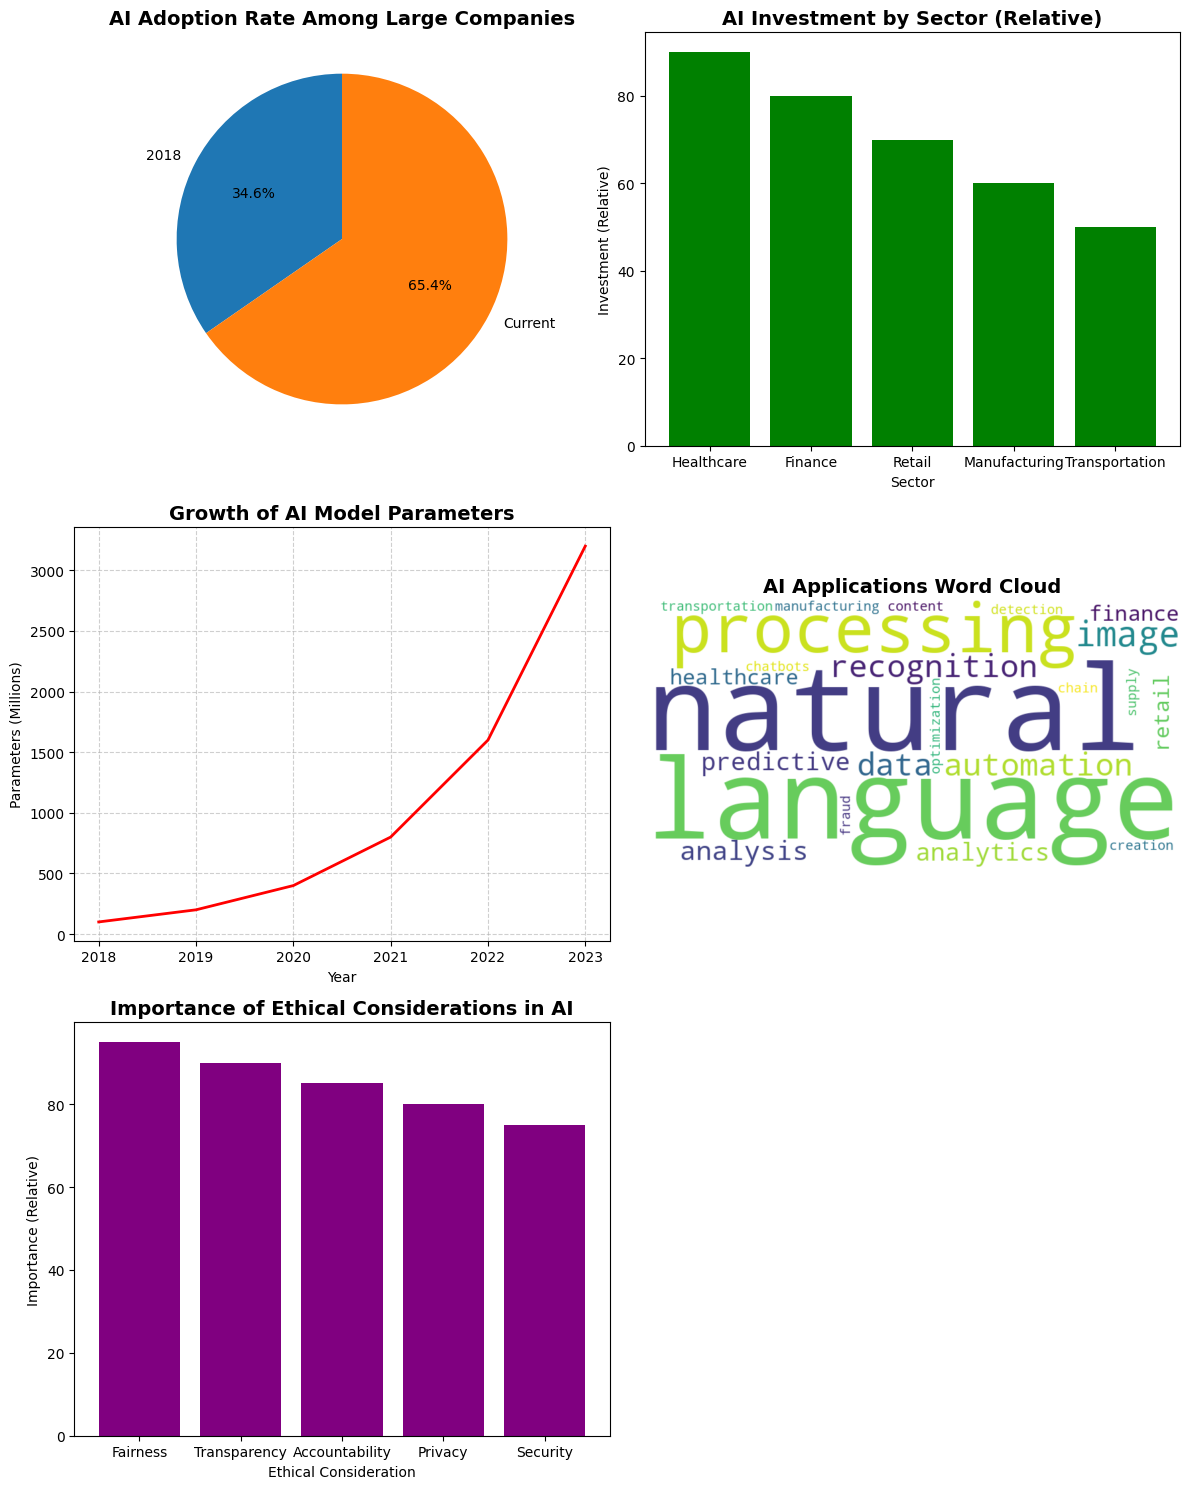

In [74]:
plot_figure(plot_funcs)

## Visualize Streamlit App with Streamlit

We've built a fully functional Streamlit app that integrates all the visualizations and tools from the agent workflow.  

You can access the app, explore the code, and run it locally by visiting the GitHub repository. Feel free to fork the repo to get access to all folders, scripts, and assets so you can experiment and run the Streamlit app yourself.  

**GitHub Repo:** [Link to your repo here]

In [96]:
!pip install streamlit pyngrok

In [83]:
ngrok_key = userdata.get("ngrock_api_key")

In [85]:
from pyngrok import ngrok

# Paste your ngrok auth token here
ngrok.set_auth_token(ngrok_key)

In [134]:
from pyngrok import ngrok
import subprocess, time

# 1. Kill old tunnels
ngrok.kill()

# 2. Start Streamlit app in the background
process = subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])

# 3. Give Streamlit a few seconds to spin up
time.sleep(5)

# 4. Open ngrok tunnel to port 8501
public_url = ngrok.connect(8501)
print("Streamlit app URL:", public_url)

Streamlit app URL: NgrokTunnel: "https://fa4feb8f378c.ngrok-free.app" -> "http://localhost:8501"
